# Simple Refridgeration Cycle

Alex Dowling, University of Notre Dame

Thank you ChatGPT!

## Import and Configure Thermodynamics

In [1]:
# Import required IDAES-PSE modules
from idaes.core import FlowsheetBlock
from idaes.models.properties.general_helmholtz import (
    HelmholtzParameterBlock,
    PhaseType,
    StateVars,
    AmountBasis,
)
from idaes.models.unit_models import (Heater, Turbine, Compressor, 
                                      Mixer, Separator, PressureChanger)
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.scaling import calculate_scaling_factors
from pyomo.environ import ConcreteModel, value, Objective, SolverFactory, maximize
from idaes.core.util.initialization import propagate_state
from pyomo.network import Arc
from pyomo.environ import units as pyunits
import numpy as np
import matplotlib.pyplot as plt

# Create the ConcreteModel and Flowsheet
model = ConcreteModel()
model.fs = FlowsheetBlock(dynamic=False)

# Add property package for a common refrigerant (e.g., R134a) using General Helmholtz model
# model.fs.properties = HelmholtzParameterBlock(pure_component="R134a", state_vars=StateVars.TPX)

# Using mass basis to make initialization easier
model.fs.properties = HelmholtzParameterBlock(pure_component="R134a", state_vars=StateVars.PH, amount_basis=AmountBasis.MASS)

## Generate Diagrams from Thermodynamics Package

Old ideas:
1. Change state variables to PH as recommended here: https://idaes-pse.readthedocs.io/en/stable/reference_guides/model_libraries/generic/property_models/helmholtz.html
2. Using the PH diagram below, guess some reasonable initial points
   - https://www.engproguides.com/pressure-enthalpy-diagram.html#:~:text=The%20left%20vertical%20curve%20indicates,indicates%20the%20saturated%20vapor%20curve.
   - https://www.researchgate.net/figure/Simple-vapour-compression-refrigeration-cycle-on-P-h-diagram_fig1_346765777
3. Initialize the flowsheet
4. Fix the temperatures as desired

New ideas:
1. Switch back to PTx state block
2. Guess initial T and P
3. Compute values for H and S
4. Plot these initial ponts


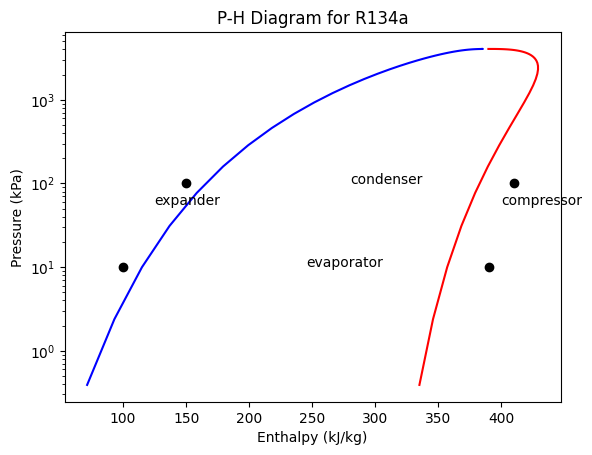

In [2]:
model.fs.properties.hp_diagram()

# guess values for initial points
h_init = [390, 410, 150, 100]
p_init = [10, 100, 100, 10]
step_names = ['compressor', 'condenser', 'expander', 'evaporator']


for i in range(len(step_names)):
    h_avg = (h_init[i] + h_init[(i+1)%4])/2
    p_avg = (p_init[i] + p_init[(i+1)%4])/2
    plt.text(h_avg, p_avg, step_names[i])

plt.plot(h_init, p_init, 'ko')

plt.show()

In [3]:
'''
from pyomo.environ import units
import pandas as pd

# Set operating conditions
high_pressure = ((85 - 32) * 5/9 + 273.15)*units.K  # Convert 130 F to Kelvin
low_pressure = ((65 - 32) * 5/9 + 273.15)*units.K   # Convert 50 F to Kelvin


points = ['A', 'B', 'C', 'D']
T = [high_pressure, low_pressure, low_pressure, high_pressure]
x = [0, 0, 1, 1]
h = np.zeros(len(points))
s = np.zeros(len(points))

for i, p in enumerate(points):
    h[i] = model.fs.properties.htpx(T=T[i], x = x[i])
    s[i] = model.fs.properties.stpx(T=T[i], x = x[i])

data = {
    'Point': points,
    'Temperature (K)': [value(temp) for temp in T],
    'Vapor Fraction': x,
    'Enthalpy (J/mol)': h,
    'Entropy (J/mol.K)': s
}

df = pd.DataFrame(data)
df.head()
'''
print("")

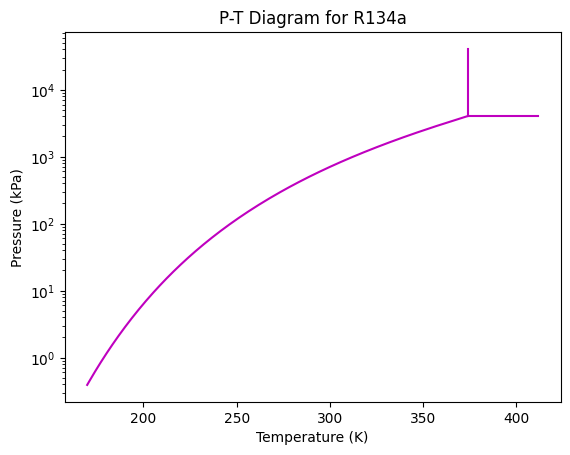

In [4]:
model.fs.properties.pt_diagram()
plt.show()

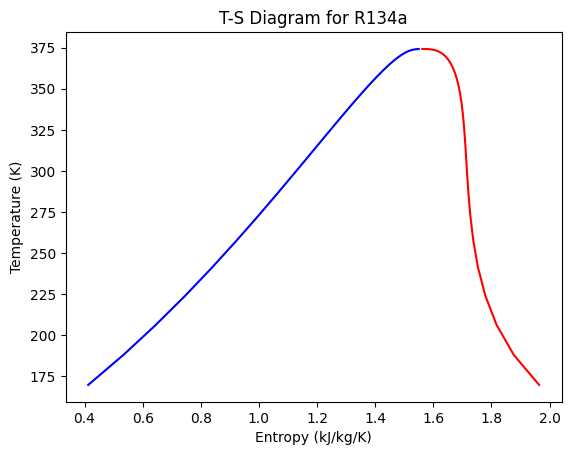

In [5]:
model.fs.properties.st_diagram()
plt.show()

## Simple Flowsheet

Challenge: Initialization is failing to convergence, possibly too few degrees of freedom for some units.

Ideas:
- Switch to alternate state representation
- Use helper functions for enthalpy and entropy to compute initial points
- Determine reasonable initial points from the phase diagrams/thermodynamic charts
- Attempt to simulate each unit operation is isolation first

Eventual enhancements:
- Plot streams from simple cycle on the three thermodyanmic charts
- Use more sophisticated thermodynamic assumption for compressor

In [6]:
import logging
# Set up logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

# Add unit models to the flowsheet
model.fs.evaporator = Heater(property_package=model.fs.properties)
model.fs.compressor = Compressor(property_package=model.fs.properties)
model.fs.condenser = Heater(property_package=model.fs.properties)
model.fs.expansion_valve = PressureChanger(property_package=model.fs.properties, 
                                           thermodynamic_assumption="isentropic")

# Connect components with arcs
model.fs.evaporator_to_compressor = Arc(source=model.fs.evaporator.outlet, 
                                        destination=model.fs.compressor.inlet)
model.fs.compressor_to_condenser = Arc(source=model.fs.compressor.outlet, 
                                       destination=model.fs.condenser.inlet)
model.fs.condenser_to_expansion_valve = Arc(source=model.fs.condenser.outlet, 
                                            destination=model.fs.expansion_valve.inlet)
model.fs.expansion_valve_to_evaporator = Arc(source=model.fs.expansion_valve.outlet, 
                                             destination=model.fs.evaporator.inlet)

scale_input_h = 1e3
scale_input_p = 1e3

# Expand arcs to build the connectivity
#from idaes.core.util import model_serializer as ms
# expand_arcs(model.fs.evaporator_to_compressor)

from pyomo.environ import TransformationFactory
TransformationFactory('network.expand_arcs').apply_to(model)

# Deactivate the flowrate constraint on one of the arcs
# model.fs.evaporator_to_compressor_expanded.flow_mol_equality.deactivate()
model.fs.evaporator_to_compressor_expanded.flow_mass_equality.deactivate()

# Evaporator (low-pressure side)
# model.fs.evaporator.inlet.flow_mol[0].fix(1)   # Example value
# model.fs.evaporator.inlet.enth_mol[0].fix(h_init[-1])
model.fs.evaporator.inlet.flow_mass[0].fix(1)   # Example value
model.fs.evaporator.inlet.enth_mass[0].fix(h_init[-1]*scale_input_h)

model.fs.evaporator.inlet.pressure[0].fix(p_init[-1]*scale_input_p)
#model.fs.evaporator.outlet.temperature[0].fix(indoor_temp - delta_T_evaporator)
#model.fs.evaporator.outlet.vapor_frac[0].fix(1.0)  # Ensure vapor phase
#model.fs.evaporator.outlet.pressure[0].fix(p_init[0]*scale_input_p)
model.fs.evaporator.outlet.enth_mass[0].fix(h_init[0]*scale_input_h)

# Compressor (compressing the vapor)
model.fs.compressor.outlet.pressure[0].fix(p_init[1]*scale_input_p)
# model.fs.compressor.outlet.enth_mass[0].fix(h_init[1]*scale_input_h)

# Condenser (high-pressure side)
# model.fs.condenser.outlet.pressure[0].fix(p_init[2]*scale_input_p)
model.fs.condenser.outlet.enth_mass[0].fix(h_init[2]*scale_input_h)

# Expansion Valve
# No pressure fix here, the outlet phase constraints handle the operation
# model.fs.expansion_valve.inlet.pressure[0].fix(p_init[3]*scale_input_p)
model.fs.expansion_valve.outlet.enth_mass[0].fix(h_init[3]*scale_input_h)

# Set up scaling and check degrees of freedom
calculate_scaling_factors(model)
# assert degrees_of_freedom(model) == 0



2025-03-07 21:39:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.evaporator.control_volume.heat


2025-03-07 21:39:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.compressor.control_volume.work


2025-03-07 21:39:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser.control_volume.heat


2025-03-07 21:39:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.expansion_valve.control_volume.work


In [7]:
logger.info("Initializing evaporator...")
model.fs.evaporator.initialize(outlvl=logging.WARNING)
model.fs.evaporator.report()


Unit : fs.evaporator                                                       Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value      : Units : Fixed : Bounds
    Heat Duty : 2.9000e+05 :  watt : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     193.85     252.62
    P                          pascal     10000.     10000.
    Vapor Fraction      dimensionless     0.0000     1.0000
    Mass Enthalpy    joule / kilogram 1.0000e+05 3.9000e+05


In [8]:
propagate_state(model.fs.evaporator_to_compressor)

In [9]:
logger.info("Initializing compressor...")
model.fs.compressor.initialize(outlvl=logging.WARNING)
model.fs.compressor.report()



Unit : fs.compressor                                                       Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                   : Value       : Units         : Fixed : Bounds
    Isentropic Efficiency :    -0.44811 : dimensionless : False : (None, None)
          Mechanical Work : -1.1854e+05 :          watt : False : (None, None)
          Pressure Change :      90000. :        pascal : False : (None, None)
           Pressure Ratio :      10.000 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     252.62     246.79
    P                          pascal     10000. 1.0000e+0

In [10]:
propagate_state(model.fs.compressor_to_condenser)

In [11]:
logger.info("Initializing condenser...")
model.fs.condenser.initialize(outlvl=logging.WARNING)
model.fs.condenser.report()


Unit : fs.condenser                                                        Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value       : Units : Fixed : Bounds
    Heat Duty : -1.2146e+05 :  watt : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     246.79     234.61
    P                          pascal 1.0000e+05 1.0000e+05
    Vapor Fraction      dimensionless    0.48820     0.0000
    Mass Enthalpy    joule / kilogram 2.7146e+05 1.5000e+05


In [12]:
propagate_state(model.fs.condenser_to_expansion_valve)

In [13]:
logger.info("Initializing expansion valve...")
model.fs.expansion_valve.initialize(outlvl=logging.WARNING)
model.fs.expansion_valve.report()



Unit : fs.expansion_valve                                                  Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                   : Value      : Units         : Fixed : Bounds
    Isentropic Efficiency :   -0.49968 : dimensionless : False : (None, None)
          Mechanical Work :    -50000. :          watt : False : (None, None)
          Pressure Change : 3.5937e+07 :        pascal : False : (None, None)
           Pressure Ratio :     360.37 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     234.61     180.14
    P                          pascal 1.0000e+05 3.6037e+07
   

In [14]:
# Unfix the conditions set previously

unit_operations = [model.fs.evaporator, model.fs.compressor, model.fs.condenser, model.fs.expansion_valve]

for unit in unit_operations:
    unit.inlet.flow_mass[0].unfix()
    unit.inlet.enth_mass[0].unfix()
    unit.inlet.pressure[0].unfix()
    unit.outlet.enth_mass[0].unfix()
    unit.outlet.pressure[0].unfix()


In [15]:
# Fix specifications for a typical refrigeration cycle

# Evaporator (low-pressure side)
model.fs.evaporator.inlet.flow_mass[0].fix(1)       # Specify the mass flow rate

# model.fs.evaporator.outlet.vapor_frac[0].fix(1.0)

# Compressor (compressing the vapor)
# model.fs.compressor.outlet.pressure[0].fix(p_init[1] * scale_input_p)

model.fs.compressor.efficiency_isentropic.fix(0.85)  # Example value

# model.fs.compressor.inlet.vapor_frac[0].fix(1)# Assume the compressor is compressing vapor
# model.fs.compressor.outlet.vapor[0].fix(1) # Assume the compressor is compressing vapor

# Condenser (high-pressure side)
# model.fs.condenser.outlet.enth_mass[0].fix(h_init[2] * scale_input_h)

model.fs.compressor.work_mechanical.setlb(0)  # Assume no work output from the compressor

# Expansion Valve
# model.fs.expansion_valve.outlet.enth_mass[0].fix(h_init[3] * scale_input_h)

# model.fs.expansion_valve.heat_duty.fix(0)  # Assume no heat loss in the expansion valve

model.fs.expansion_valve.work_isentropic.fix(0)  # Assume no work input/output
model.fs.expansion_valve.work_mechanical.fix(0)  # Assume no work input/output

# Set up scaling and check degrees of freedom
calculate_scaling_factors(model)
assert degrees_of_freedom(model) >= 0

In [16]:
# Add objective function to maximize the coefficient of performance (COP)
'''
model.fs.COP = Objective(expr=(model.fs.evaporator.outlet.flow_mass[0] * 
                               (model.fs.evaporator.outlet.enth_mass[0] - model.fs.evaporator.inlet.enth_mass[0])) /
                         (model.fs.compressor.work_mechanical[0]), sense=maximize)
'''

model.fs.cooling = Objective(expr=model.fs.condenser.heat_duty[0], sense=maximize)

# Solver setup
solver = get_solver()

# solver.options = {'max_iter': 10}

# Solve the model
results = solver.solve(model, tee=True)

# Print results
if results.solver.termination_condition == 'optimal':
    print("Refrigeration cycle solved successfully.")
    # print("Coefficient of Performance (COP):", value(model.fs.COP))
    # print("Evaporator outlet temperature:", value(model.fs.evaporator.outlet.temperature[0]))
    # print("Compressor outlet phase:", model.fs.compressor.outlet.phase[0].value)
    # print("Condenser outlet temperature:", value(model.fs.condenser.outlet.temperature[0]))
    # print("Condenser outlet phase:", model.fs.condenser.outlet.phase[0].value)
else:
    print("Refrigeration cycle did not converge.")

model.fs.report()



Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes fo

In [17]:
for unit in unit_operations:
    unit.report()


Unit : fs.evaporator                                                       Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value       : Units : Fixed : Bounds
    Heat Duty : -4.0000e+05 :  watt : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     359.26     169.55
    P                          pascal 7.8704e+05 7.8704e+05
    Vapor Fraction      dimensionless     1.0000     0.0000
    Mass Enthalpy    joule / kilogram 4.7146e+05     71455.

Unit : fs.compressor                                                       Time: 0.0
---------------------------------------------------------------------

In [18]:
model.fs.compressor.display()

Block fs.compressor

  Variables:
    _flow_mass_inlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.compressor.control_volume.properties_in[...].component('flow_mass')
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
        0.0 :  None : 0.9999999999134568 :  None : False : False :  Reals
    _enth_mass_inlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.compressor.control_volume.properties_in[...].component('enth_mass')
        Key : Lower             : Value             : Upper             : Fixed : Stale : Domain
        0.0 : 71454.99461781095 : 71454.99461781095 : 471458.4755146525 : False : False :  Reals
    _pressure_inlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.compressor.control_volume.properties_in[...].component('pressure')
        Key : Lower                  : Value             : Upper      : Fixed : Stale : Domain
        0.0 : 1.0000000000000002e-06 : 787042.8412870973 : 70000000.0 : False : False : PositiveReals
    _flow_mass_outlet_ref :